In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the cleaned dataset
data = pd.read_csv('cleaned_student_data2.csv')

# Define the target and features
target = 'G3'
features = data.drop(columns=[target])
sensitive_feature = 'age'

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['G3_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive feature
data['age_bin'] = pd.cut(data['age'], bins=5, labels=False)


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, data['G3_binary'], test_size=0.2, random_state=42)

# Reset indices to ensure alignment
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Define a function to calculate different metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

# Base Model Training
rf_model_base = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_base.fit(X_train, y_train)

# Predict using the trained base model
y_pred_base = rf_model_base.predict(X_test)

# Compute metrics for different groups for the base model
metrics_base = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_base,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print the overall metrics for the base model
print("Overall Metrics for Base Model:")
print(metrics_base.overall)

# Print metrics by sensitive feature groups for the base model
print("\nMetrics by Sensitive Feature Groups for Base Model:")
print(metrics_base.by_group)


Overall Metrics for Base Model:
{'accuracy': 0.8481012658227848, 'precision': 0.8125, 'recall': 0.9285714285714286, 'f1': 0.8666666666666667}

Metrics by Sensitive Feature Groups for Base Model:
age_bin
0    {'accuracy': 0.8461538461538461, 'precision': ...
1    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


In [3]:
# Custom Reweighing Function
def compute_sample_weights(X, y, sensitive_feature):
    df = X.copy()
    df['y'] = y
    df['sensitive'] = sensitive_feature
    # Calculate group counts
    group_counts = df.groupby('sensitive')['y'].count()
    group_positive_counts = df.groupby('sensitive')['y'].sum()
    group_negative_counts = group_counts - group_positive_counts
    # Calculate weights
    positive_weight = 1.0 / group_positive_counts
    negative_weight = 1.0 / group_negative_counts
    df['weight'] = df.apply(lambda row: positive_weight[row['sensitive']] if row['y'] == 1 else negative_weight[row['sensitive']], axis=1)
    return df['weight'].values

# Apply reweighing
sample_weights = compute_sample_weights(X_train, y_train, data.loc[X_train.index, 'age_bin'])

# Train a Random Forest model with reweighed samples
rf_model_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predict using the trained reweighed model
y_pred_rw = rf_model_rw.predict(X_test)

# Compute metrics for the reweighed model
metrics_rw = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_rw,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

# Print the overall metrics for the reweighed model
print("Overall Metrics for Reweighed Model:")
print(metrics_rw.overall)

# Print metrics by sensitive feature groups for the reweighed model
print("\nMetrics by Sensitive Feature Groups for Reweighed Model:")
print(metrics_rw.by_group)


Overall Metrics for Reweighed Model:
{'accuracy': 0.8734177215189873, 'precision': 0.82, 'recall': 0.9761904761904762, 'f1': 0.8913043478260869}

Metrics by Sensitive Feature Groups for Reweighed Model:
age_bin
0    {'accuracy': 0.8717948717948718, 'precision': ...
1    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


In [4]:
# Define custom fairness metric functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_positive_rate_difference(y_true, y_pred, sensitive_feature):
    groups = np.unique(sensitive_feature)
    rates = []
    for group in groups:
        mask = (sensitive_feature == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_feature):
    groups = np.unique(sensitive_feature)
    rates = []
    for group in groups:
        mask = (sensitive_feature == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_feature):
    groups = np.unique(sensitive_feature)
    rates = []
    for group in groups:
        mask = (sensitive_feature == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)


In [5]:
# Adversarial Debiasing
adv_model = LogisticRegression(solver='liblinear', random_state=42)
adv_debias = ExponentiatedGradient(adv_model, constraints=DemographicParity(), eps=0.01)
adv_debias.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'age_bin'])
y_pred_adv = adv_debias.predict(X_test)

metrics_adv = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_adv,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

print("Overall Metrics for Adversarial Debiasing Model:")
print(metrics_adv.overall)

print("\nMetrics by Sensitive Feature Groups for Adversarial Debiasing Model:")
print(metrics_adv.by_group)


Overall Metrics for Adversarial Debiasing Model:
{'accuracy': 0.8607594936708861, 'precision': 0.8444444444444444, 'recall': 0.9047619047619048, 'f1': 0.8735632183908046}

Metrics by Sensitive Feature Groups for Adversarial Debiasing Model:
age_bin
0    {'accuracy': 0.8589743589743589, 'precision': ...
1    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


In [6]:
# Post-processing using ThresholdOptimizer
post_proc = ThresholdOptimizer(estimator=rf_model_rw, constraints="demographic_parity", prefit=True, predict_method='predict')
post_proc.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'age_bin'])
y_pred_post_proc = post_proc.predict(X_test, sensitive_features=data.loc[X_test.index, 'age_bin'].astype(str))

metrics_post_proc = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_post_proc,
    sensitive_features=data.loc[X_test.index, 'age_bin']
)

print("Overall Metrics for Post-processing Model:")
print(metrics_post_proc.overall)

print("\nMetrics by Sensitive Feature Groups for Post-processing Model:")
print(metrics_post_proc.by_group)


Overall Metrics for Post-processing Model:
{'accuracy': 0.46835443037974683, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

Metrics by Sensitive Feature Groups for Post-processing Model:
age_bin
0    {'accuracy': 0.46153846153846156, 'precision':...
1    {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
Name: compute_metrics, dtype: object


In [7]:
# Recompute fairness metrics for all models
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fprd = false_positive_rate_difference(y_true, y_pred, sensitive_features)
    fnrd = false_negative_rate_difference(y_true, y_pred, sensitive_features)
    srd = selection_rate_difference(y_pred, sensitive_features)
    for_diff = false_omission_rate_difference(y_true, y_pred, sensitive_features)
    tnr_diff = true_negative_rate_difference(y_true, y_pred, sensitive_features)
    
    return {
        'Demographic Parity Difference': dpd,
        'Equalized Odds Difference': eod,
        'False Positive Rate Difference': fprd,
        'False Negative Rate Difference': fnrd,
        'Selection Rate Difference': srd,
        'False Omission Rate Difference': for_diff,
        'True Negative Rate Difference': tnr_diff
    }

# Calculate fairness metrics for all models
fairness_metrics_base = calculate_fairness_metrics(y_test, y_pred_base, data.loc[X_test.index, 'age_bin'])
fairness_metrics_rw = calculate_fairness_metrics(y_test, y_pred_rw, data.loc[X_test.index, 'age_bin'])
fairness_metrics_adv = calculate_fairness_metrics(y_test, y_pred_adv, data.loc[X_test.index, 'age_bin'])
fairness_metrics_post_proc = calculate_fairness_metrics(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'])

# Summarize all fairness metrics for all models
summary_metrics_base = {
    'Demographic Parity Difference': fairness_metrics_base['Demographic Parity Difference'],
    'Equalized Odds Difference': fairness_metrics_base['Equalized Odds Difference'],
    'False Positive Rate Difference': fairness_metrics_base['False Positive Rate Difference'],
    'False Negative Rate Difference': fairness_metrics_base['False Negative Rate Difference'],
    'Selection Rate Difference': fairness_metrics_base['Selection Rate Difference']
}

summary_metrics_rw = {
    'Demographic Parity Difference': fairness_metrics_rw['Demographic Parity Difference'],
    'Equalized Odds Difference': fairness_metrics_rw['Equalized Odds Difference'],
    'False Positive Rate Difference': fairness_metrics_rw['False Positive Rate Difference'],
    'False Negative Rate Difference': fairness_metrics_rw['False Negative Rate Difference'],
    'Selection Rate Difference': fairness_metrics_rw['Selection Rate Difference']
}

summary_metrics_adv = {
    'Demographic Parity Difference': fairness_metrics_adv['Demographic Parity Difference'],
    'Equalized Odds Difference': fairness_metrics_adv['Equalized Odds Difference'],
    'False Positive Rate Difference': fairness_metrics_adv['False Positive Rate Difference'],
    'False Negative Rate Difference': fairness_metrics_adv['False Negative Rate Difference'],
    'Selection Rate Difference': fairness_metrics_adv['Selection Rate Difference']
}

summary_metrics_post_proc = {
    'Demographic Parity Difference': fairness_metrics_post_proc['Demographic Parity Difference'],
    'Equalized Odds Difference': fairness_metrics_post_proc['Equalized Odds Difference'],
    'False Positive Rate Difference': fairness_metrics_post_proc['False Positive Rate Difference'],
    'False Negative Rate Difference': fairness_metrics_post_proc['False Negative Rate Difference'],
    'Selection Rate Difference': fairness_metrics_post_proc['Selection Rate Difference']
}

# Compare results of all models
comparison_all = pd.DataFrame({
    'Metric': ['Demographic Parity Difference', 'Equalized Odds Difference', 'False Positive Rate Difference', 'False Negative Rate Difference', 'Selection Rate Difference'],
    'Base Model': [fairness_metrics_base['Demographic Parity Difference'], fairness_metrics_base['Equalized Odds Difference'], fairness_metrics_base['False Positive Rate Difference'], fairness_metrics_base['False Negative Rate Difference'], fairness_metrics_base['Selection Rate Difference']],
    'Reweighed Model': [fairness_metrics_rw['Demographic Parity Difference'], fairness_metrics_rw['Equalized Odds Difference'], fairness_metrics_rw['False Positive Rate Difference'], fairness_metrics_rw['False Negative Rate Difference'], fairness_metrics_rw['Selection Rate Difference']],
    'Adversarial Debiasing Model': [fairness_metrics_adv['Demographic Parity Difference'], fairness_metrics_adv['Equalized Odds Difference'], fairness_metrics_adv['False Positive Rate Difference'], fairness_metrics_adv['False Negative Rate Difference'], fairness_metrics_adv['Selection Rate Difference']],
    'Post-Processing Model': [fairness_metrics_post_proc['Demographic Parity Difference'], fairness_metrics_post_proc['Equalized Odds Difference'], fairness_metrics_post_proc['False Positive Rate Difference'], fairness_metrics_post_proc['False Negative Rate Difference'], fairness_metrics_post_proc['Selection Rate Difference']]
})

print("\nComparison of Fairness Metrics between all Models:")
print(comparison_all)



Comparison of Fairness Metrics between all Models:
                           Metric  Base Model  Reweighed Model  \
0   Demographic Parity Difference    0.615385         0.641026   
1       Equalized Odds Difference    0.928571         0.976190   
2  False Positive Rate Difference    0.250000         0.250000   
3  False Negative Rate Difference         NaN              NaN   
4       Selection Rate Difference    0.615385         0.641026   

   Adversarial Debiasing Model  Post-Processing Model  
0                     0.576923                    0.0  
1                     0.904762                    0.0  
2                     0.194444                    0.0  
3                          NaN                    NaN  
4                     0.576923                    0.0  


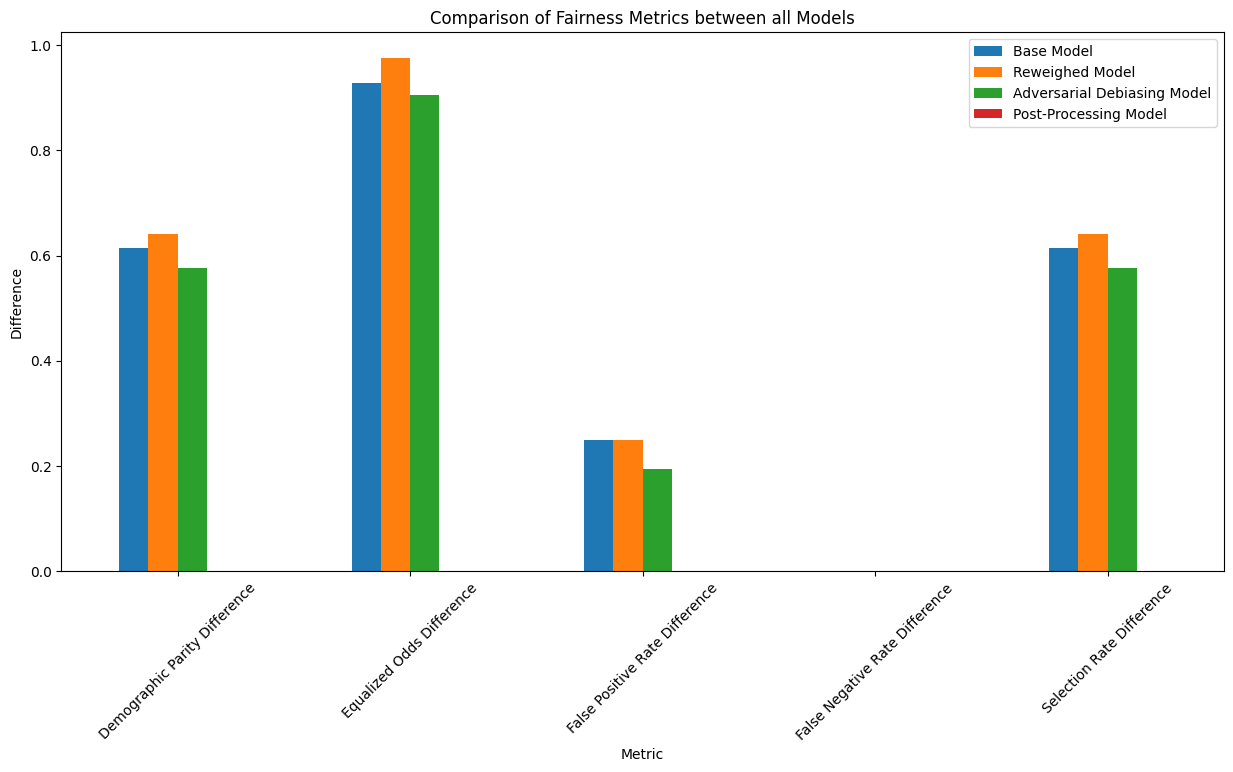

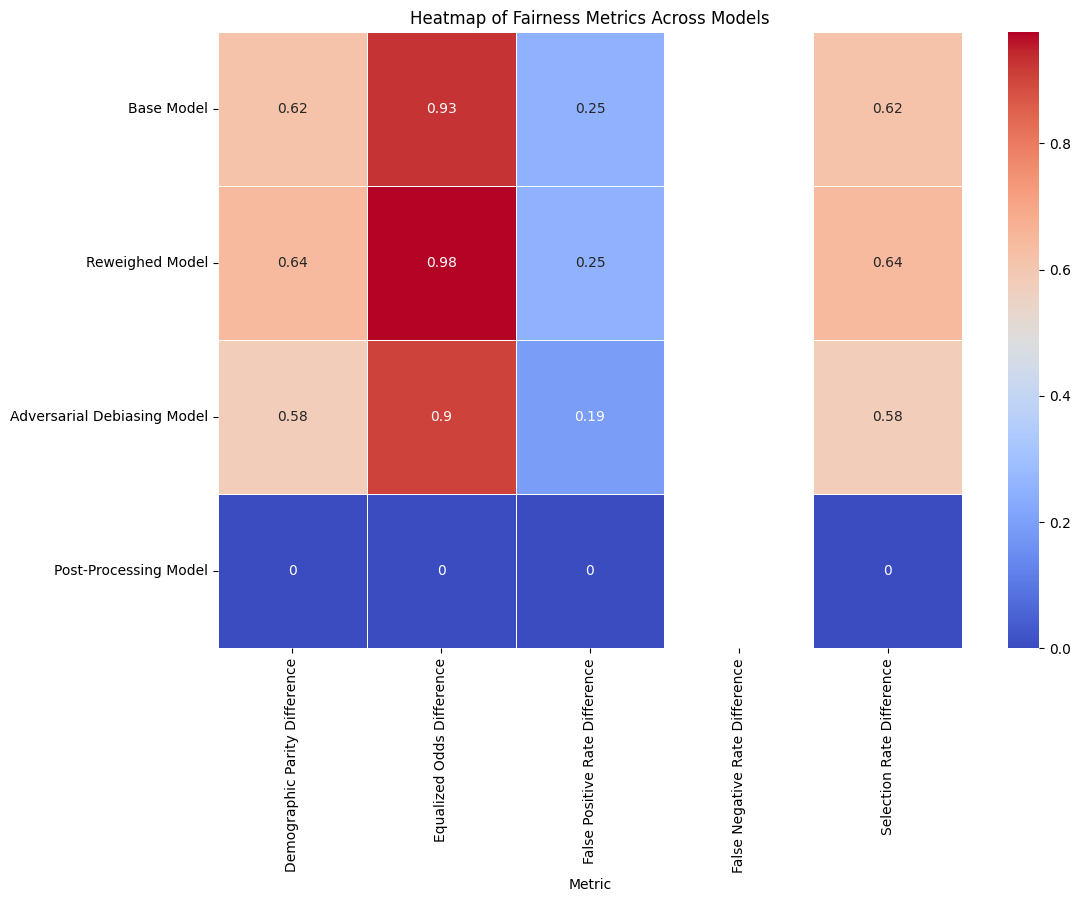

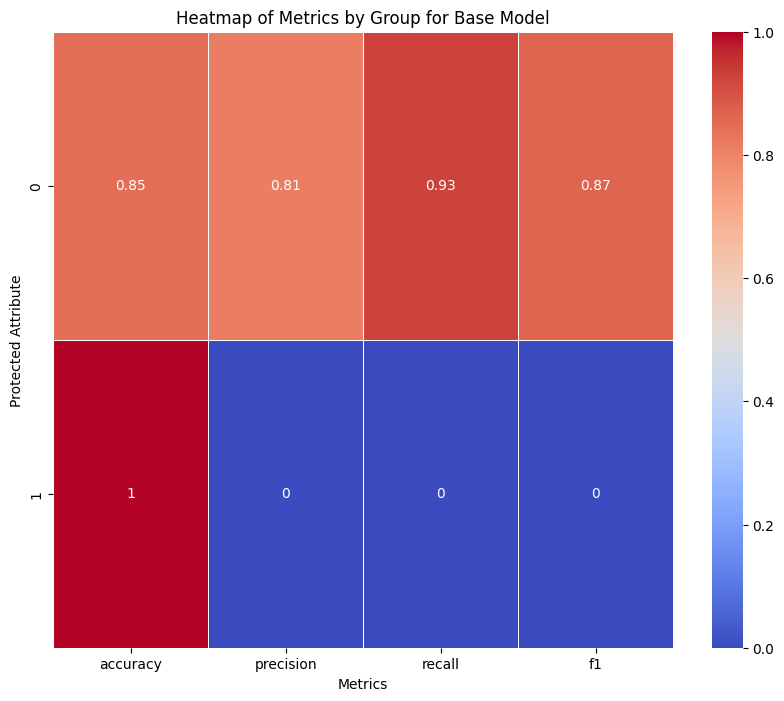

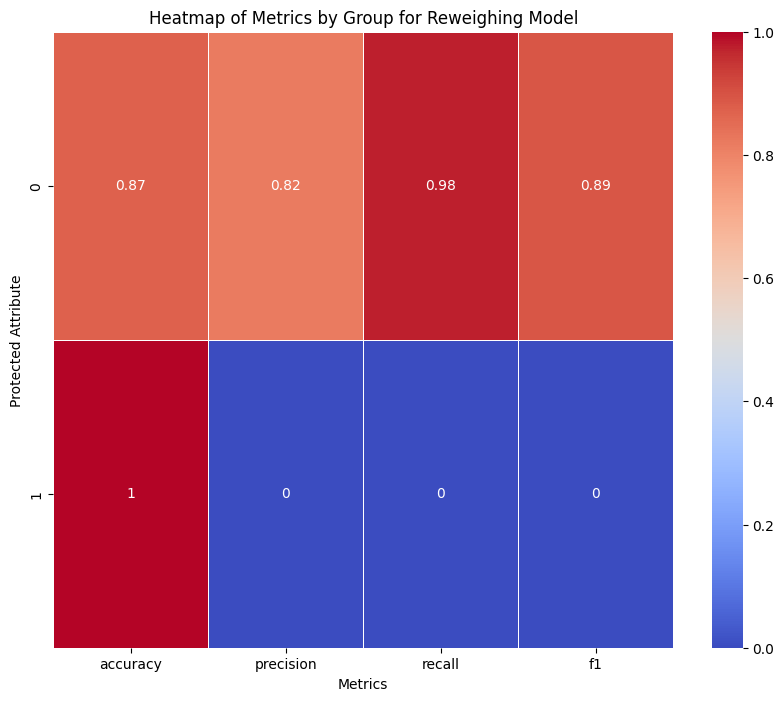

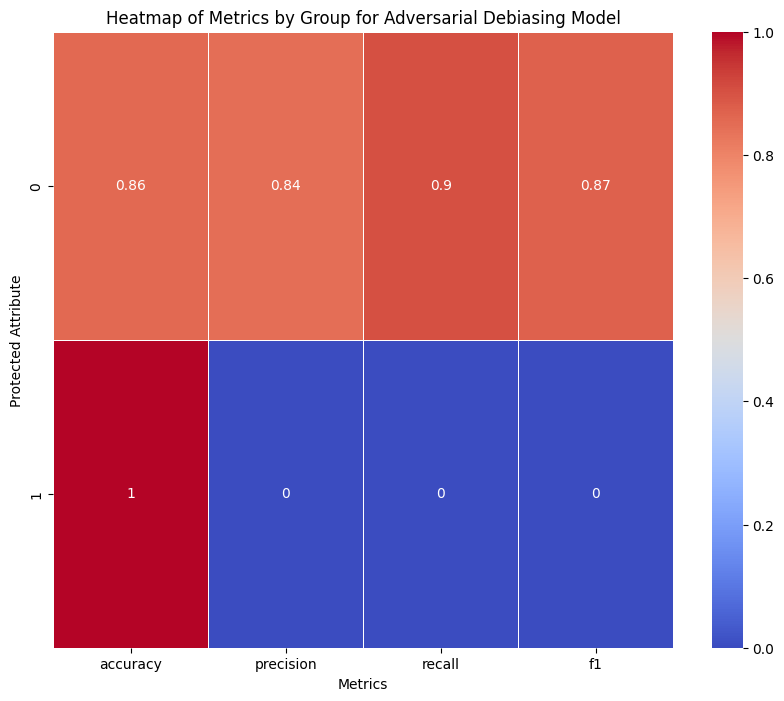

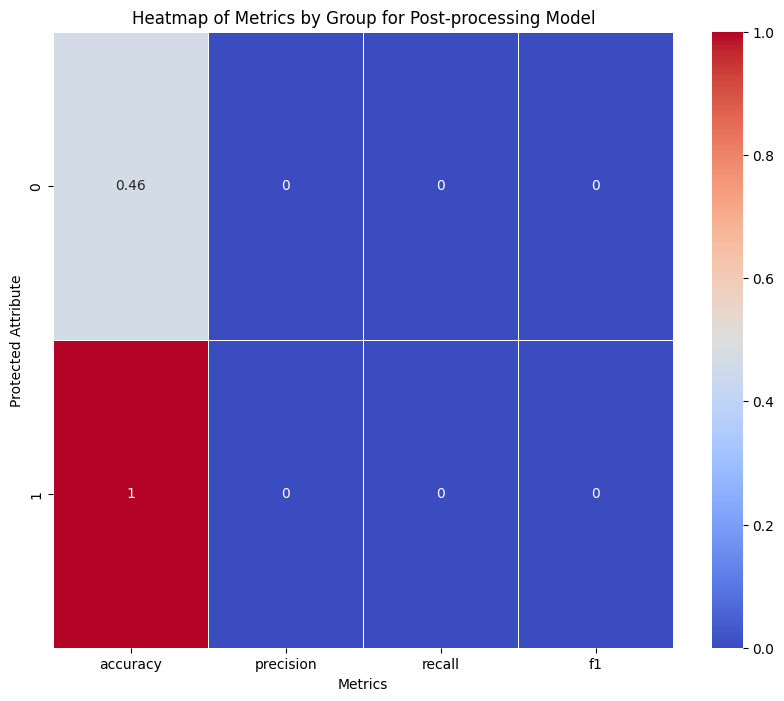

In [8]:
# Plot comparison of fairness metrics
comparison_all.set_index('Metric').plot(kind='bar', figsize=(15, 7))
plt.title('Comparison of Fairness Metrics between all Models')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.show()

# Prepare data for heatmap
heatmap_data = comparison_all.set_index('Metric').transpose()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Fairness Metrics Across Models')
plt.show()

# Additional Visualization Functions

def plot_model_heatmap(model_name, metrics_by_group):
    plt.figure(figsize=(10, 8))
    sns.heatmap(metrics_by_group, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title(f'Heatmap of Metrics by Group for {model_name}')
    plt.ylabel('Protected Attribute')
    plt.xlabel('Metrics')
    plt.show()

# Extract metrics by group for all models
metrics_by_group_base = metrics_base.by_group.apply(pd.Series)
metrics_by_group_rw = metrics_rw.by_group.apply(pd.Series)
metrics_by_group_adv = metrics_adv.by_group.apply(pd.Series)
metrics_by_group_post_proc = metrics_post_proc.by_group.apply(pd.Series)

# Heatmaps for each model
plot_model_heatmap("Base Model", metrics_by_group_base)
plot_model_heatmap("Reweighing Model", metrics_by_group_rw)
plot_model_heatmap("Adversarial Debiasing Model", metrics_by_group_adv)
plot_model_heatmap("Post-processing Model", metrics_by_group_post_proc)


Comparison of Fairness Metrics between all Models:
                           Metric  Base Model  Reweighed Model  \
0   Demographic Parity Difference    0.615385         0.641026   
1       Equalized Odds Difference    0.928571         0.976190   
2  False Positive Rate Difference    0.250000         0.250000   
3  False Negative Rate Difference         NaN              NaN   
4       Selection Rate Difference    0.615385         0.641026   

   Adversarial Debiasing Model  Post-Processing Model  
0                     0.576923                    0.0  
1                     0.904762                    0.0  
2                     0.194444                    0.0  
3                          NaN                    NaN  
4                     0.576923                    0.0  


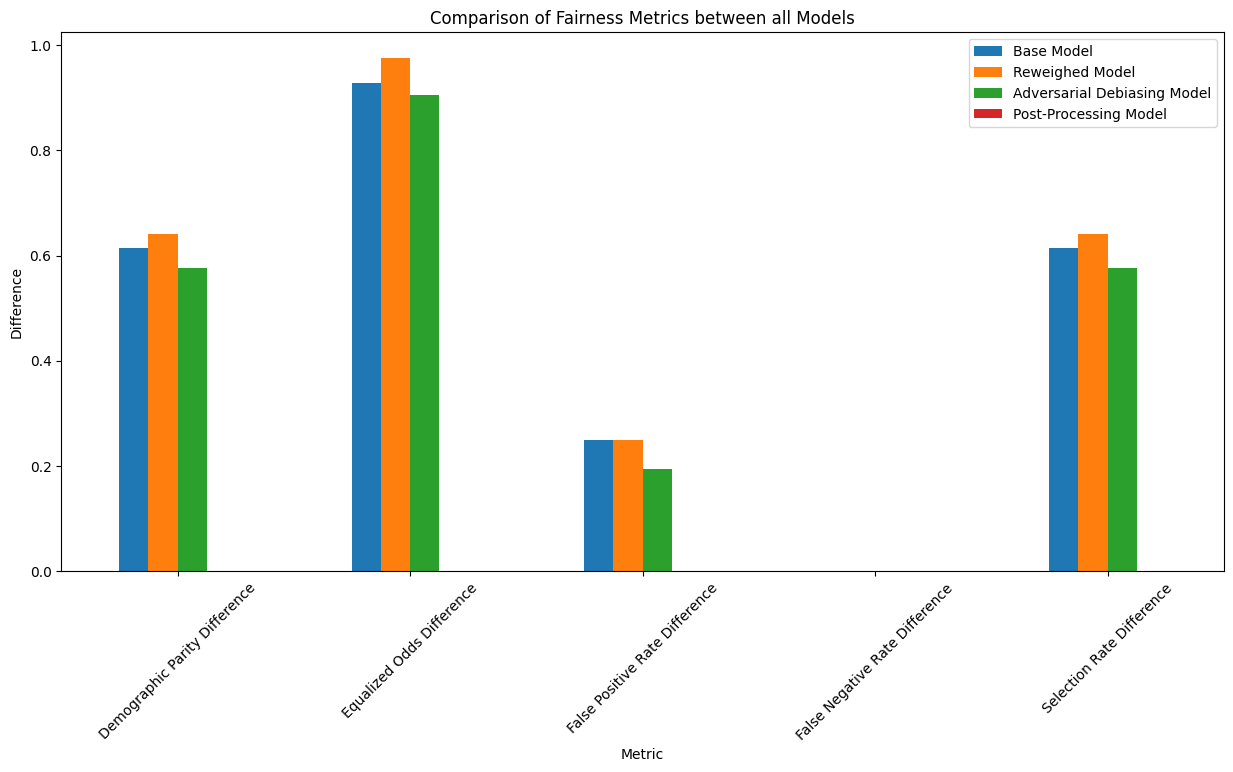

In [9]:
# Summarize all fairness metrics for all models
summary_metrics_base = {
    'Demographic Parity Difference': fairness_metrics_base['Demographic Parity Difference'],
    'Equalized Odds Difference': fairness_metrics_base['Equalized Odds Difference'],
    'False Positive Rate Difference': fairness_metrics_base['False Positive Rate Difference'],
    'False Negative Rate Difference': fairness_metrics_base['False Negative Rate Difference'],
    'Selection Rate Difference': fairness_metrics_base['Selection Rate Difference']
}

summary_metrics_rw = {
    'Demographic Parity Difference': fairness_metrics_rw['Demographic Parity Difference'],
    'Equalized Odds Difference': fairness_metrics_rw['Equalized Odds Difference'],
    'False Positive Rate Difference': fairness_metrics_rw['False Positive Rate Difference'],
    'False Negative Rate Difference': fairness_metrics_rw['False Negative Rate Difference'],
    'Selection Rate Difference': fairness_metrics_rw['Selection Rate Difference']
}

summary_metrics_adv = {
    'Demographic Parity Difference': fairness_metrics_adv['Demographic Parity Difference'],
    'Equalized Odds Difference': fairness_metrics_adv['Equalized Odds Difference'],
    'False Positive Rate Difference': fairness_metrics_adv['False Positive Rate Difference'],
    'False Negative Rate Difference': fairness_metrics_adv['False Negative Rate Difference'],
    'Selection Rate Difference': fairness_metrics_adv['Selection Rate Difference']
}

summary_metrics_post_proc = {
    'Demographic Parity Difference': fairness_metrics_post_proc['Demographic Parity Difference'],
    'Equalized Odds Difference': fairness_metrics_post_proc['Equalized Odds Difference'],
    'False Positive Rate Difference': fairness_metrics_post_proc['False Positive Rate Difference'],
    'False Negative Rate Difference': fairness_metrics_post_proc['False Negative Rate Difference'],
    'Selection Rate Difference': fairness_metrics_post_proc['Selection Rate Difference']
}

# Compare results of all models
comparison_all = pd.DataFrame({
    'Metric': ['Demographic Parity Difference', 'Equalized Odds Difference', 'False Positive Rate Difference', 'False Negative Rate Difference', 'Selection Rate Difference'],
    'Base Model': [fairness_metrics_base['Demographic Parity Difference'], fairness_metrics_base['Equalized Odds Difference'], fairness_metrics_base['False Positive Rate Difference'], fairness_metrics_base['False Negative Rate Difference'], fairness_metrics_base['Selection Rate Difference']],
    'Reweighed Model': [fairness_metrics_rw['Demographic Parity Difference'], fairness_metrics_rw['Equalized Odds Difference'], fairness_metrics_rw['False Positive Rate Difference'], fairness_metrics_rw['False Negative Rate Difference'], fairness_metrics_rw['Selection Rate Difference']],
    'Adversarial Debiasing Model': [fairness_metrics_adv['Demographic Parity Difference'], fairness_metrics_adv['Equalized Odds Difference'], fairness_metrics_adv['False Positive Rate Difference'], fairness_metrics_adv['False Negative Rate Difference'], fairness_metrics_adv['Selection Rate Difference']],
    'Post-Processing Model': [fairness_metrics_post_proc['Demographic Parity Difference'], fairness_metrics_post_proc['Equalized Odds Difference'], fairness_metrics_post_proc['False Positive Rate Difference'], fairness_metrics_post_proc['False Negative Rate Difference'], fairness_metrics_post_proc['Selection Rate Difference']]
})

print("\nComparison of Fairness Metrics between all Models:")
print(comparison_all)

# Plot comparison of fairness metrics
comparison_all.set_index('Metric').plot(kind='bar', figsize=(15, 7))
plt.title('Comparison of Fairness Metrics between all Models')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.show()

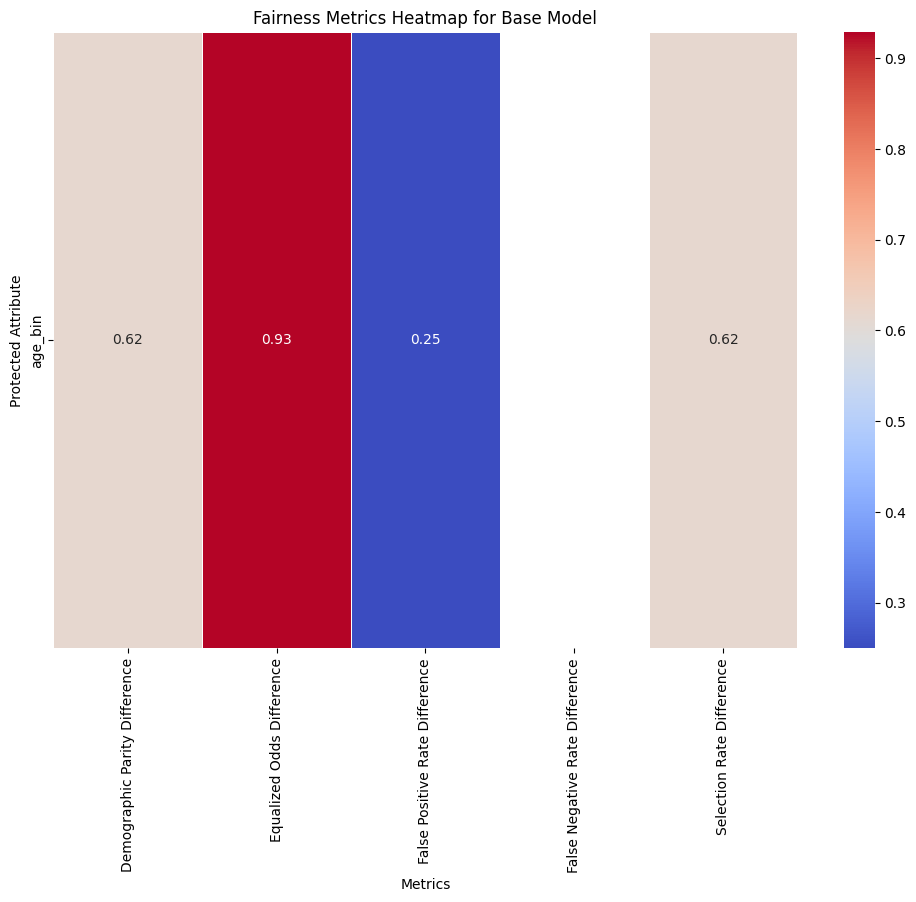

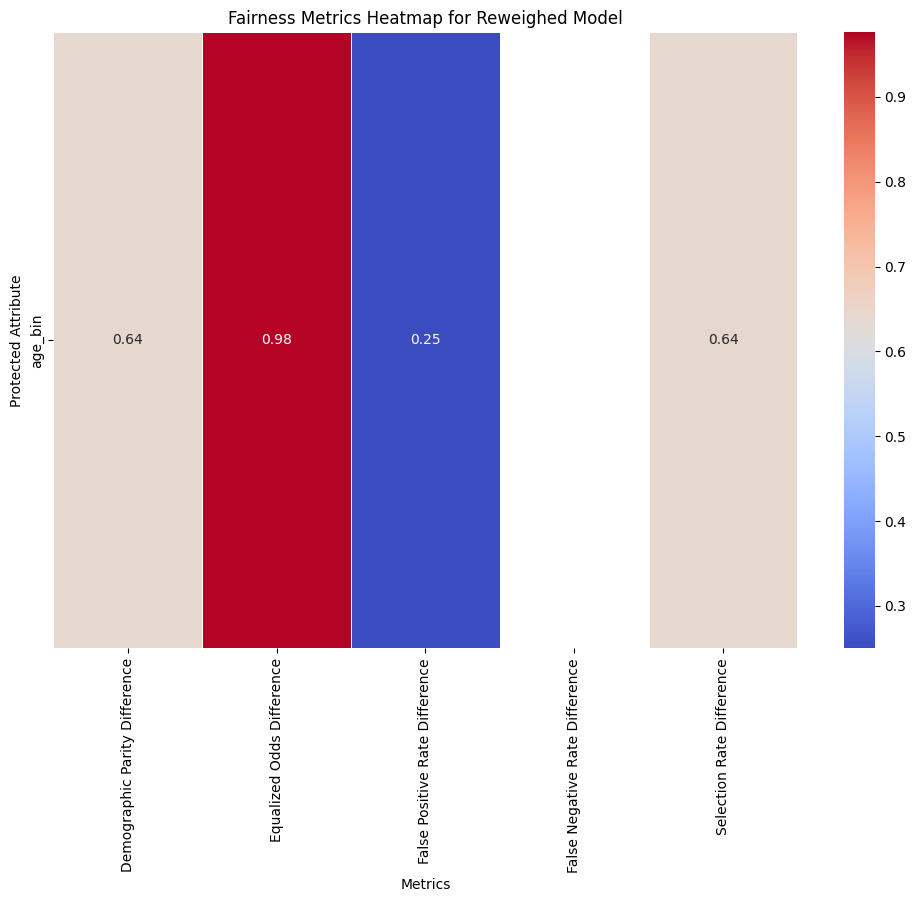

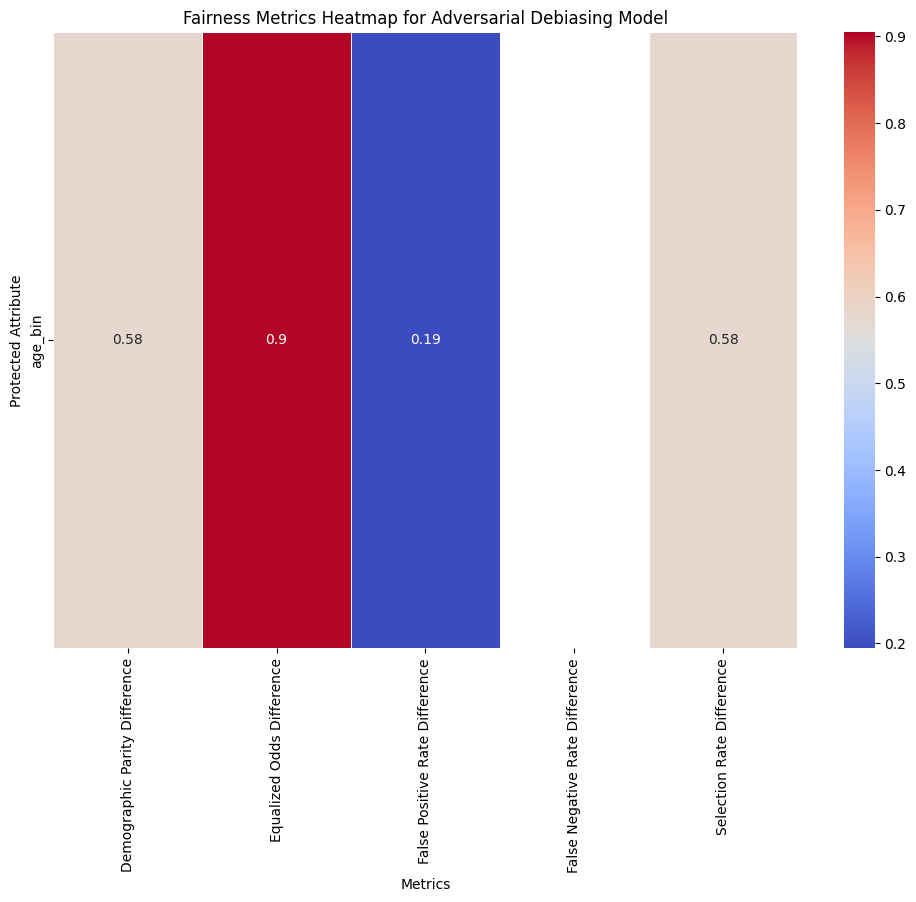

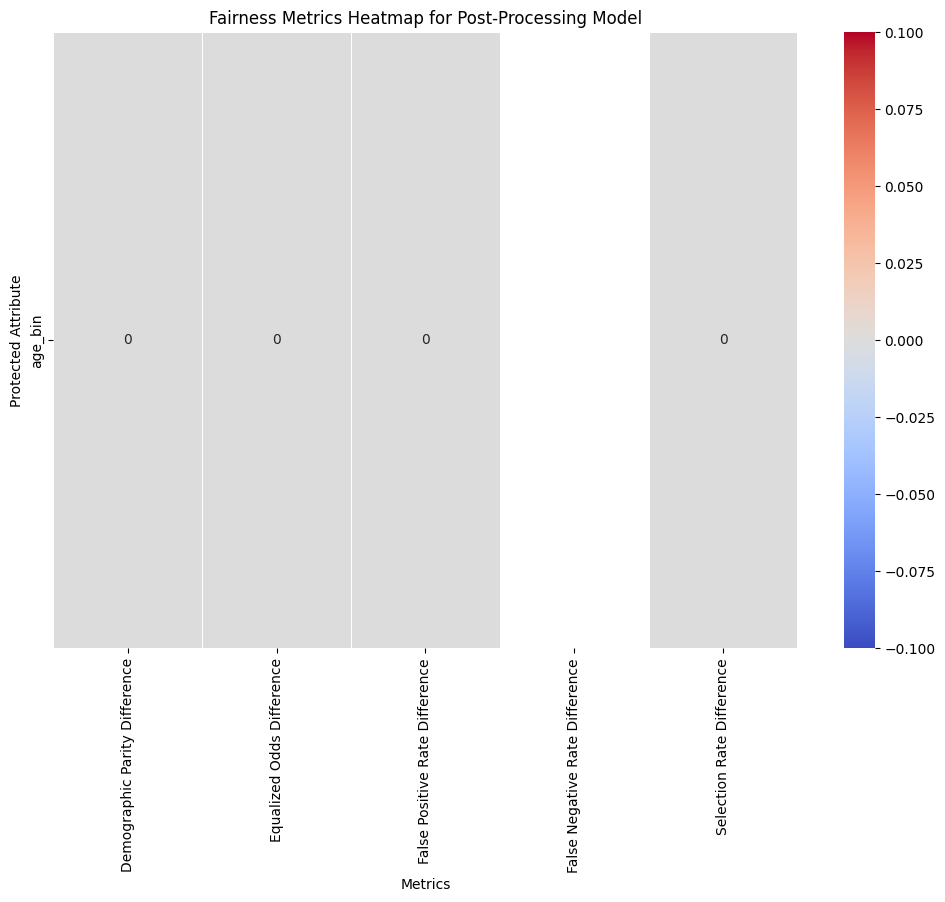

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap for fairness metrics of the base model
metrics_heatmap_base_data = pd.DataFrame({
    'Demographic Parity Difference': [fairness_metrics_base['Demographic Parity Difference']],
    'Equalized Odds Difference': [fairness_metrics_base['Equalized Odds Difference']],
    'False Positive Rate Difference': [fairness_metrics_base['False Positive Rate Difference']],
    'False Negative Rate Difference': [fairness_metrics_base['False Negative Rate Difference']],
    'Selection Rate Difference': [fairness_metrics_base['Selection Rate Difference']]
}, index=['age_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_base_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap for Base Model')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Create heatmap for fairness metrics of the reweighed model
metrics_heatmap_rw_data = pd.DataFrame({
    'Demographic Parity Difference': [fairness_metrics_rw['Demographic Parity Difference']],
    'Equalized Odds Difference': [fairness_metrics_rw['Equalized Odds Difference']],
    'False Positive Rate Difference': [fairness_metrics_rw['False Positive Rate Difference']],
    'False Negative Rate Difference': [fairness_metrics_rw['False Negative Rate Difference']],
    'Selection Rate Difference': [fairness_metrics_rw['Selection Rate Difference']]
}, index=['age_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_rw_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap for Reweighed Model')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Create heatmap for fairness metrics of the adversarial debiasing model
metrics_heatmap_adv_data = pd.DataFrame({
    'Demographic Parity Difference': [fairness_metrics_adv['Demographic Parity Difference']],
    'Equalized Odds Difference': [fairness_metrics_adv['Equalized Odds Difference']],
    'False Positive Rate Difference': [fairness_metrics_adv['False Positive Rate Difference']],
    'False Negative Rate Difference': [fairness_metrics_adv['False Negative Rate Difference']],
    'Selection Rate Difference': [fairness_metrics_adv['Selection Rate Difference']]
}, index=['age_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_adv_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap for Adversarial Debiasing Model')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Create heatmap for fairness metrics of the post-processing model
metrics_heatmap_post_proc_data = pd.DataFrame({
    'Demographic Parity Difference': [fairness_metrics_post_proc['Demographic Parity Difference']],
    'Equalized Odds Difference': [fairness_metrics_post_proc['Equalized Odds Difference']],
    'False Positive Rate Difference': [fairness_metrics_post_proc['False Positive Rate Difference']],
    'False Negative Rate Difference': [fairness_metrics_post_proc['False Negative Rate Difference']],
    'Selection Rate Difference': [fairness_metrics_post_proc['Selection Rate Difference']]
}, index=['age_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_post_proc_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap for Post-Processing Model')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()


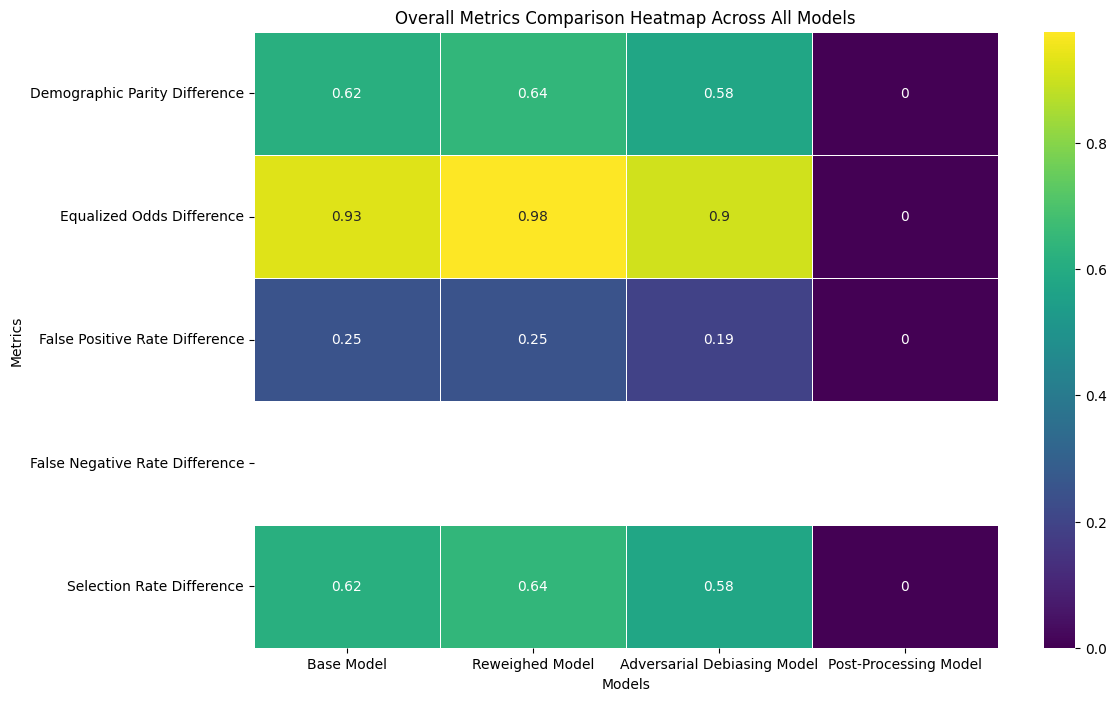

In [11]:
# Comparison heatmap for overall metrics across all models
comparison_heatmap_data = pd.DataFrame({
    'Base Model': [
        fairness_metrics_base['Demographic Parity Difference'], 
        fairness_metrics_base['Equalized Odds Difference'], 
        fairness_metrics_base['False Positive Rate Difference'], 
        fairness_metrics_base['False Negative Rate Difference'], 
        fairness_metrics_base['Selection Rate Difference']
    ],
    'Reweighed Model': [
        fairness_metrics_rw['Demographic Parity Difference'], 
        fairness_metrics_rw['Equalized Odds Difference'], 
        fairness_metrics_rw['False Positive Rate Difference'], 
        fairness_metrics_rw['False Negative Rate Difference'], 
        fairness_metrics_rw['Selection Rate Difference']
    ],
    'Adversarial Debiasing Model': [
        fairness_metrics_adv['Demographic Parity Difference'], 
        fairness_metrics_adv['Equalized Odds Difference'], 
        fairness_metrics_adv['False Positive Rate Difference'], 
        fairness_metrics_adv['False Negative Rate Difference'], 
        fairness_metrics_adv['Selection Rate Difference']
    ],
    'Post-Processing Model': [
        fairness_metrics_post_proc['Demographic Parity Difference'], 
        fairness_metrics_post_proc['Equalized Odds Difference'], 
        fairness_metrics_post_proc['False Positive Rate Difference'], 
        fairness_metrics_post_proc['False Negative Rate Difference'], 
        fairness_metrics_post_proc['Selection Rate Difference']
    ]
}, index=[
    'Demographic Parity Difference', 
    'Equalized Odds Difference', 
    'False Positive Rate Difference', 
    'False Negative Rate Difference', 
    'Selection Rate Difference'
])

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap Across All Models')
plt.ylabel('Metrics')
plt.xlabel('Models')
plt.show()